简答题：
1. 如果你的训练集具有数百万个特征，那么可以使用哪种线性回归训练算法？

使用随机梯度下降或小批量梯度下降

2. 如果你的训练集里特征的数值大小迥异，那么哪些算法可能会受到影响？受影响程度如何？你应该怎么做？

梯度下降算法需要很长时间才能收敛。在训练模型之前缩放数据


3. 训练逻辑回归模型时，梯度下降可能会卡在局部最小值中吗？

梯度下降不会陷入局部最小值


4. 如果你让它们运行足够长的时间，是否所有的梯度下降算法都能得出相同的模型？

梯度下降算法可能会收敛，但结果可能会有差异


5. 假设你使用批量梯度下降，并在每个轮次绘制验证误差。如果你发现验证错误持续上升，那么可能是什么情况？你该如何解决？

如果验证错误在每个轮次后持续上升，则一种可能性是学习率过高并且算法在发散。如果训练错误也增加了，应该降低学习率。但是，如果训练错误没有增加，则模型已经过拟合训练集，则应该停止训练


6. 当验证误差上升时立即停止小批量梯度下降是个好主意吗？

停止训练是一个好主意，因为这可以防止模型过拟合


7. 哪种梯度下降算法（在我们讨论过的算法中）将最快地到达最佳解附近？哪个实际上会收敛？如何使其他的也收敛

随机梯度下降法具有最快的训练迭代速度。实际上只有批量梯度下降会收敛。适当调整学习率可以使其他的也收敛


8. 假设你正在使用多项式回归。绘制学习曲线后，你会发现训练误差和验证误差之间存在很大的差距。发生了什么？解决此问题的三种方法是什么？

发生了过拟合。增加训练数据、正则化、简化模型


9. 假设你正在使用岭回归，并且你注意到训练误差和验证误差几乎相等且相当高。你是否会说模型存在高偏差或高方差？你应该增加正则化超参数α还是减小它呢？

该模型很可能欠拟合训练集，它具有很高的偏差。减少正则化超参数α


10. 为什么要使用：a.岭回归而不是简单的线性回归（即没有任何正则化）？b.Lasso而不是岭回归？c.弹性网络而不是Lasso回归？

a.防止过拟合、在大量特征的情况下，仍然可以工作。b.Lasso回归自动执行特征选择并输出具有很少非零特征权重的系数模型。c.当特征数量超过训练实例数量，又或者是几个特征强相关时，Lasso回归的表现可能非常不稳定。


11. 假设你要将图片分类为室外/室内和白天/夜间。你应该实现两个逻辑回归分类器还是一个softmax回归分类器？

训练两个逻辑回归分类器


编程题：

In [183]:
# todo 编程题: 在不使用sklearn的情况下，仅使用Numpy，为softmax回归实现带早停的批量梯度下降，将它用于分类任务，
#  例如鸢尾花数据集  load_iris, 只用两个特征就可以："petal width (cm)", "petal length (cm)"
#  强调：除了读数据，其他全用numpy （包括分离测试+验证），不用sklearn

#  注意：
#  1. 要实现l2正则化
#  2. 除了数据读取，其他仅使用numpy，包括训练集+验证集分离，以及softmax预测 和 损失计算

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

X = iris.data[["petal width (cm)", "petal length (cm)"]].values
y = iris.target

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
test_size = int(0.2 * len(X))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [74]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, max_iterations=1000, tolerance=1e-6, 
                 regularization_strength=0.01, patience=10):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.regularization_strength = regularization_strength
        self.patience = patience
        self.weights = None
        self.bias = None
        self.costs = []
        self.val_costs = []
        
    def softmax(self, z):
        # 为了数值稳定性，减去最大值
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def one_hot_encode(self, y, num_classes):
        one_hot = np.zeros((len(y), num_classes))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot
    
    def compute_cost(self, y_pred, y_true):
        m = y_true.shape[0]
        cross_entropy_loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / m
        l2_regularization = (self.regularization_strength / (2 * m)) * np.sum(self.weights ** 2)
        return cross_entropy_loss + l2_regularization
    
    def fit(self, X, y, X_val=None, y_val=None):
        m, n = X.shape
        num_classes = len(np.unique(y))
        self.weights = np.random.normal(0, 0.01, (n, num_classes))
        self.bias = np.zeros((1, num_classes))
        
        y_train_one_hot = self.one_hot_encode(y, num_classes)
        if X_val is not None:
            y_val_one_hot = self.one_hot_encode(y_val, num_classes)

        best_val_cost = np.inf
        patience_counter = 0
        best_weights = self.weights.copy()
        best_bias = self.bias.copy()
        
        for i in range(self.max_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(z)
            
            train_cost = self.compute_cost(y_pred, y_train_one_hot)
            self.costs.append(train_cost)
            
            if X_val is not None:
                z_val = np.dot(X_val, self.weights) + self.bias
                y_val_pred = self.softmax(z_val)
                val_cost = self.compute_cost(y_val_pred, y_val_one_hot)
                self.val_costs.append(val_cost)
                
                if val_cost < best_val_cost:
                    best_val_cost = val_cost
                    patience_counter = 0
                    best_weights = self.weights.copy()
                    best_bias = self.bias.copy()
                else:
                    patience_counter += 1
                    
                if patience_counter >= self.patience:
                    self.weights = best_weights
                    self.bias = best_bias
                    break
            
            dw = (1/m) * np.dot(X.T, (y_pred - y_train_one_hot)) + \
                 (self.regularization_strength/m) * self.weights
            db = (1/m) * np.sum(y_pred - y_train_one_hot, axis=0, keepdims=True)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if i > 0 and abs(self.costs[-2] - self.costs[-1]) < self.tolerance:
                break
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z)
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)


In [75]:
model = SoftmaxRegression(
    learning_rate=0.1,
    max_iterations=1000,
    regularization_strength=0.01,
    patience=20
)

model.fit(X_train, y_train, X_test, y_test)

y_train_pred = model.predict(X_train)
train_accuracy = np.mean(y_train_pred == y_train)

In [76]:
train_accuracy

0.9583333333333334

In [77]:
y_val_pred = model.predict(X_test)
val_accuracy = np.mean(y_val_pred == y_test)

In [78]:
val_accuracy

0.9666666666666667

In [79]:
y_train_one_hot = model.one_hot_encode(y_train, len(np.unique(y)))
train_pred_proba = model.predict_proba(X_train)
final_train_loss = model.compute_cost(train_pred_proba, y_train_one_hot)

In [80]:
final_train_loss

0.14290712103145076

最终验证损失: 0.1401


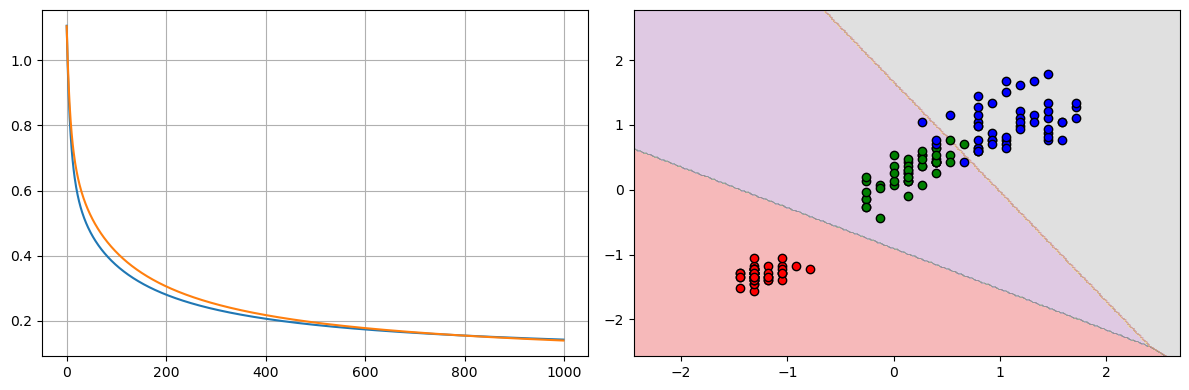

In [84]:
if len(model.val_costs) > 0:
    print(f"最终验证损失: {model.val_costs[-1]:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model.costs)
if model.val_costs:
    plt.plot(model.val_costs)
plt.grid(True)

plt.subplot(1, 2, 2)
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], edgecolors='black')

plt.tight_layout()
plt.show()